In [1]:
import numpy as np
import os, sys
import json

project_root = os.path.abspath("")  # alternative
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
import torch.optim as optim
import time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # makes fonts editable in Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42
from torch.utils.tensorboard import SummaryWriter

from utils import remove_all_ticks_and_labels

global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}', flush=True)

2023-11-22 19:39:06.264483: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-22 19:39:06.692842: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using device: cuda


In [15]:
description = {
    'model_name': 'large-noisy-image-classifier',
    'model_num': 9,
    'architecture': 'NetWithNoiseInfo',
    'num_hidden': 32,
    'dataset': 'mnist',
    'num_epochs': 1e2,
    'lr': 3e-3,
    'num_steps': 150,
    'batch_size': 512,
    'num_in': 28*28,
    'schedule': 'sigmoid',
    'start': 1e-7,
    'end': 1e-1,
    'notes': 'training on noisy images.'
}
# save description
with open(os.path.join(base_dir, 'core', 'model_description', f'{description["model_name"]}_{description["model_num"]}.json'), 'w') as f:
    json.dump(description, f)

In [16]:
from torchvision import datasets, transforms
mnist_dir = os.path.join(base_dir, 'core', 'datasets', 'mnist')

mnist_train = datasets.MNIST(mnist_dir, train=True, download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    # transforms.Normalize((0.1307,), (0.3081,))
                ]))

# mnist_train.targets
print(mnist_train[0][1])

# ------------------------------- select digits ------------------------------ #
train_loader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=description['batch_size'], shuffle=True)

5


In [23]:
# training 
from image_utils import generate_many_noisy_samples, rescale_to_neg_one_to_one
global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}', flush=True)

def classifier_loss(model, x, labels, num_classes, num_steps, schedule, start, end):
    '''
    Calculates the loss associated with the model's prediction of the data. 
    This fn is given a batch of data with associated labels. 
    '''
    batch_size = x.shape[0]
    # x = x.reshape(batch_size, -1)
    x = rescale_to_neg_one_to_one(x)
    
    # add noise to the data
    t = torch.randint(0, num_steps, size=(batch_size,), device=device).long()
    # x_noisy = generate_many_noisy_samples(num_steps, x, t, schedule, start, end, device).reshape(batch_size, -1)
    x_noisy = generate_many_noisy_samples(num_steps, x, t, schedule, start, end, device)
    output = model(x_noisy, t)  # the output is from a softmax, so it produces a probability of each discrete class
    # output = model(x_noisy)  # the output is from a softmax, so it produces a probability of each discrete class
    c = torch.nn.functional.one_hot(labels, num_classes).to(torch.float)  # encodes the classes with a one hot encoding
    
    # loss = (c - output).square().mean()
    loss = torch.nn.functional.cross_entropy(output, c)
    return loss

from models import NetWithNoiseInfo, NetNoNoiseInfo
# classifier = NetNoNoiseInfo(norm_method='nn', num_channels=description['num_hidden'], num_steps=description['num_steps'])
classifier = NetWithNoiseInfo(norm_method='nn', num_channels=description['num_hidden'], num_steps=description['num_steps'])
classifier.to(device)
classifier.train()
num_epochs = int(description['num_epochs'])

optimizer = optim.Adam(classifier.parameters(), lr=description['lr'])

run_dir = os.path.join(base_dir, 'demos/runs', f'{description["model_name"]}_{description["model_num"]}')
tb = SummaryWriter(run_dir, flush_secs=1)

for epoch in tqdm(range(1, int(num_epochs) + 1), total=int(num_epochs), desc='Training model', unit='epochs', miniters=int(num_epochs)/100, maxinterval=float("inf")):
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        loss = classifier_loss(classifier, data, target, 10, description['num_steps'], description['schedule'], description['start'], description['end'])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tb.add_scalar('Loss', loss.item(), epoch+batch_idx)

print('training is over at last')

# save model weights
from utils import save_model_weights
save_model_weights(classifier, description['model_name'], description['model_num'])
tb.flush()

Using device: cuda


Training model:   0%|          | 0/100 [00:00<?, ?epochs/s]

training is over at last
model state dict saved in directory: /mnt/ceph/users/blyo1/projects/LyoSavin2023/core/saved_weights/large-noisy-image-classifier_9.pt


torch.Size([100, 1, 28, 28])
probs tensor([[0.0000e+00, 7.3794e-01, 2.6206e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 6.5861e-44, 9.1448e-36, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 4.0831e-36, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.0229e-26, 0.0000e+00, 3.6434e-44, 4.0918e-43],
        [1.0000e+00, 7.5342e-20, 4.3094e-38, 1.8809e-35, 9.8225e-25, 1.5295e-06,
         6.3550e-09, 2.3194e-36, 8.6213e-14, 1.4167e-38],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.1145e-24],
        [1.7758e-01, 0.0000e+00, 0.0000e+00, 7.3843e-36, 0.0000e+00, 2.4289e-20,
         0.0000e+00, 8.0722e-15, 0.0000e+00, 8.2242e-01],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.4078e-45, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 4.7740e-33, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.6541e-30, 1.0558e-38, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 8.6824e-14, 2.1458e-38, 8.819

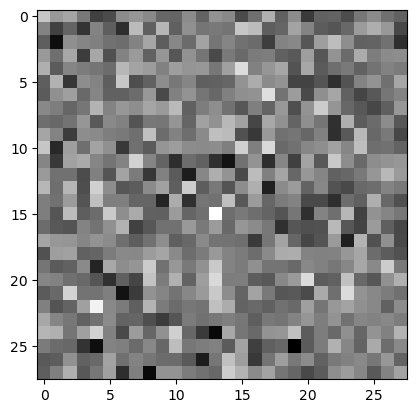

In [29]:
# test the model performance
from utils import load_model_weights
from image_utils import generate_many_noisy_samples, rescale_to_neg_one_to_one
model_name = 'large-noisy-image-classifier'
model_num = 9

desc_dir = os.path.join(base_dir, 'core', 'model_description', f'{model_name}_{model_num}.json')
# load json file form desc_dir
with open(desc_dir, 'r') as f:
    description = json.load(f)

# load model weights
load_model = True

if load_model == True:
    from models import LargeNoisyImageClassifier, NetNoNoiseInfo, NetWithNoiseInfo
    # model = LargeNoisyImageClassifier(num_in=description['num_in'], num_hidden=description['num_hidden'], num_classes=10, num_steps=description['num_steps'])
    # model = NetNoNoiseInfo(norm_method='nn', num_channels=description['num_hidden'])
    model = NetWithNoiseInfo(norm_method='nn', num_channels=description['num_hidden'], num_steps=description['num_steps'])
    model = model.to(device)
    from utils import load_model_weights
    model_name = f"{description['model_name']}_{description['model_num']}.pt"
    loadpath = os.path.join(base_dir, f'core/saved_weights', model_name)
    state_dict = torch.load(loadpath, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    
# load data
def test_classifier_accuracy(model, num_test_samples,):
    import torch
    from torchvision import datasets, transforms
    mnist_dir = os.path.join(base_dir, 'core', 'datasets', 'mnist')
    mnist_test = datasets.MNIST(mnist_dir, train=False, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                    ]))

    test_loader = torch.utils.data.DataLoader(
        mnist_test,
        batch_size=num_test_samples, shuffle=True)

    test_data = mnist_test.data[0][0]
    # test the model
    for batch_idx, (test_data, test_targets) in enumerate(test_loader):
        test_data = test_data.to(device)
        
        test_data = rescale_to_neg_one_to_one(test_data)
        # print(test_data.min(), test_data.max())
        
        test_targets = test_targets.to(device)
        # add noise to image
        
        testset_size = test_data.shape[0]
        noise_level = 120
        assert noise_level < description['num_steps']
        t = torch.tensor([noise_level])
        t = t.repeat(testset_size,).long().cuda()
        noisy_test_data = generate_many_noisy_samples(description['num_steps'], test_data, t, description['schedule'], description['start'], description['end'], device)
        print(noisy_test_data.shape)
        fig, ax = plt.subplots(1, 1)
        ax.imshow(noisy_test_data[0].squeeze().cpu().numpy(), cmap='gray')
        
        probs = model(noisy_test_data, t)
        pred = probs.max(dim=1)[1]
        print('probs', probs[:10])
        print(f'predictions: {pred[:10]}')
        print(f'correct: {test_targets[:10]}')
        
        num_correct = pred.eq(test_targets.view_as(pred)).sum().item()
        
        acc = num_correct / testset_size
        print(acc)
        break

test_classifier_accuracy(model, 100)

# perform inference

In [33]:
# load diffusion model
diffusion_model_name = 'dendritic-mnist'
diffusion_model_num = 32

desc_dir = os.path.join(base_dir, 'core', 'model_description', f'{diffusion_model_name}_{diffusion_model_num}.json')
# load json file form desc_dir
with open(desc_dir, 'r') as f:
    diff_params = json.load(f)
    
if diff_params['model_name'] == 'dendritic-mnist':
    from models import VariableDendriticCircuit
    diffusion_model = VariableDendriticCircuit(hidden_cfg=diff_params['hidden_cfg'], 
                                    num_in=diff_params['num_ambient_dims'], 
                                    num_out=diff_params['num_ambient_dims'], 
                                    bias=True)
    # load diffusion_model weights
    diffusion_model = diffusion_model.to(device)
    from utils import load_model_weights
    diffusion_model = load_model_weights(diffusion_model, diff_params['model_name'], diff_params['model_number'], device)
    diffusion_model.eval()

# -------------------------------- classifier -------------------------------- #
# load classifier
classifier_model_name = 'large-noisy-image-classifier'
classifier_model_num = 9

desc_dir = os.path.join(base_dir, 'core', 'model_description', f'{classifier_model_name}_{classifier_model_num}.json')
# load json file form desc_dir
with open(desc_dir, 'r') as f:
    class_params = json.load(f)
    
if description['model_name'] == 'large-noisy-image-classifier':
    from models import NetNoNoiseInfo, NetWithNoiseInfo
    classifier = NetWithNoiseInfo(norm_method='nn', num_channels=description['num_hidden'], num_steps=description['num_steps'])
    classifier = classifier.to(device)
    from utils import load_model_weights
    classifier = load_model_weights(classifier, class_params['model_name'], class_params['model_num'], device)
    classifier.eval()

model loaded!
model loaded!


In [34]:
diffusion_model

VariableDendriticCircuit(
  (nonlin): ReLU()
  (features): MySequential(
    (0): NoiseConditionalLinearConcat1(
      (linear): Linear(in_features=785, out_features=112896, bias=True)
    )
    (1): ReLU()
    (2): DendriticBranchLayer()
    (3): ReLU()
    (4): DendriticBranchLayer()
  )
)

In [182]:
# now perform inference
from image_utils import perform_top_down_inference, p_sample_loop_large

label = 3
s_td = 0
sample_size = 2
schedule = 'sigmoid'
# start = class_params['start']
# end = class_params['end']
start=2e-7
end=12e-2
print(start, end)
shape = (sample_size, diff_params['num_ambient_dims'])

# x_seq = p_sample_loop_large(diffusion_model, shape, 150, device, None, schedule, start, end)[-1]

x_seq, classifier_scores = perform_top_down_inference(diffusion_model, classifier, 150, label, s_td, shape, schedule, start, end, device)
print(x_seq.shape)
print(classifier_scores.shape)
print(classifier_scores[14].max())

x_seq = x_seq[-1].reshape(sample_size, 28, 28).detach()
# x_seq = rescale_to_neg_one_to_one(x_seq)
# x_seq = x_seq.reshape(sample_size, 28, 28)

fig, axes = plt.subplots(1, sample_size)
for idx, a in enumerate(axes):
    a.imshow(x_seq[idx].squeeze().cpu().numpy(), cmap='gray')
    remove_all_ticks_and_labels(a)

2e-07 0.12
torch.Size([151, 2, 784])
torch.Size([150, 2, 784])
tensor(2.4332, device='cuda:0')


RuntimeError: shape '[2, 28, 28]' is invalid for input of size 236768

In [92]:
# show distribution of mnist
mnist_train = datasets.MNIST(mnist_dir, train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                    ]))

train_loader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=1, shuffle=True)

def count_mnist_labels(train_loader):
    label_counts = np.zeros(10)
    for batch_idx, (data, target) in enumerate(train_loader):
        label_counts[target] += 1
    return label_counts

label_counts = count_mnist_labels(train_loader)

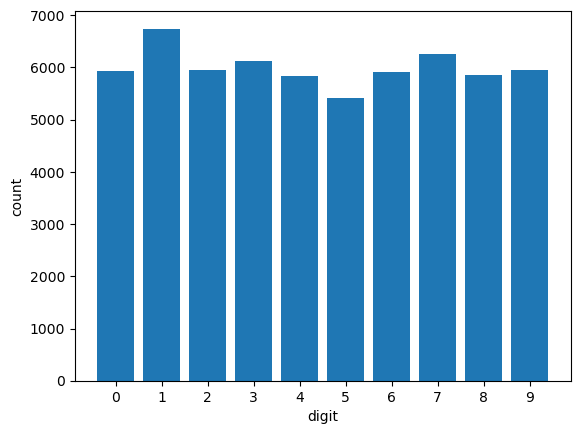

In [95]:
fig, ax = plt.subplots(1, 1)
ax.bar(np.arange(10), label_counts)
a = ax.set(xticks=np.arange(10), xticklabels=np.arange(10), xlabel='digit', ylabel='count')


torch.Size([5000, 1, 28, 28])
predictions: tensor([2, 6, 3, 2, 5, 1, 2, 2, 9, 2], device='cuda:0')


<BarContainer object of 10 artists>

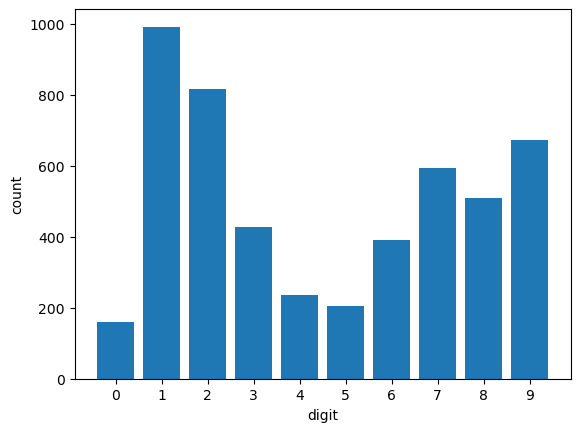

In [131]:
# show distribution of generated samples
load_dir = os.path.join(base_dir, 'core', 'saved_arrays', 'mnist')
x_0 = np.load(os.path.join(load_dir, f'generated_samples_model32.npy'))
x_0 = torch.tensor(x_0)
print(x_0.shape)

# run classifier on generated samples
x_0 = x_0.to(device)
x_0 = rescale_to_neg_one_to_one(x_0)

t = torch.tensor([0])
t = t.repeat(x_0.shape[0],).long().cuda()

probs = classifier(x_0, t)
pred = probs.max(dim=1)[1]
print(f'predictions: {pred[:10]}')

# show distribution of generated samples
def count_generated_labels(x_0, pred):
    label_counts = np.zeros(10)
    for idx in range(x_0.shape[0]):
        label_counts[pred[idx]] += 1
    return label_counts

counts = count_generated_labels(x_0, pred)
fig, ax = plt.subplots(1, 1)
a = ax.set(xticks=np.arange(10), xticklabels=np.arange(10), xlabel='digit', ylabel='count')
ax.bar(np.arange(10), counts)